# MLP Training and Testing

Sample code to train and test a simple MLP with CSI data extracted from a variational autoencoder.

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TF log and warnings

import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import keras
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

from scipy.stats import dirichlet

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [14]:
np.random.seed(0) # predictable random numbers, for demonstration only

# computes golden ratio for figures
def goldenrect(h):
    return (h * 1.618, h)

def summary_clf(y_test, predicted, y_score, _labels = None):
    print(classification_report(y_test, predicted, labels= _labels))

## Load dataset

The `latent_space_dataset` directory contains some datasets of CSI that have been already processed by the VAE. The VAE has been trained without any information about the target classes; it just tries to minimize reconstruction loss + KL loss.

The Encoder in the VAE maps sequences of CSI into **2 Gaussian variables** with parameters (z_mean, z_log_var).

More in detail, from the dataset we load `data` and `labels`.
- `data`: every element is a 4-tuple with the values (z1_mean, z2_mean, z1_log_var, z2_log_var)
- `labels`: 5 different classes, labelled with integers from 0 to 4 (0 = walk, 1 = run, 2 = jump, 3 = sit, 4 = empty)

Available datasets:
- `single_antenna`: data of just antenna 1, normalized wrt to the maximum value over the entire dataset (four antennas are available, numbered from 0 to 3)
- `four_antennas`: data of the four antennas fused together, normalized wrt to the maximum value over the entire dataset
- `four_antennas_latent_space_3`: same as `four_antennas`, but the CSI is mapped onto 3 Gaussian variables; hence, every element in `data` is a 6-tuple with the values (z1_mean, z2_mean, z3_mean, z1_log_var, z2_log_var, z3_log_var)

In [15]:
semantic_classes = ["Walk", "Run", "Jump", "Sit", "Empty"]
base_directory = './results'
os.makedirs(base_directory, exist_ok=True)

In [16]:
def load_experiment(name, _test_size = 0.2, _random_state = 42):
    data = None
    labels = None
    
    # features columns
    fcolumns = ['mu1','mu2','sigma1','sigma2']
    
    # check which experiments we wants to load
    if name == "No-Fused-1":
        with open('./latent_space_dataset/single_antenna_0.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "No-Fused-2":
        with open('./latent_space_dataset/single_antenna_1.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "No-Fused-3":
        with open('./latent_space_dataset/single_antenna_2.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "No-Fused-4":
        with open('./latent_space_dataset/single_antenna_3.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "Early-Fusing":
        with open('./latent_space_dataset/four_antennas.pkl', 'rb') as f:
            data, labels = pickle.load(f)
    elif name == "Early-Fusing3": # Same as Early-Fusing, but mapping the input data onto 3-dim Gaussian variables
        with open('./latent_space_dataset/four_antennas_latent_space_3.pkl', 'rb') as f:
            fcolumns = ['mu1','mu2', 'mu3', 'sigma1','sigma2','sigma3']
            data, labels = pickle.load(f)
    elif name == "Delayed-Fusing":
        fcolumns=[
                    'mu1_0','mu2_0','sigma1_0','sigma2_0',
                    'mu1_1','mu2_1','sigma1_1','sigma2_1',
                    'mu1_2','mu2_2','sigma1_2','sigma2_2',
                    'mu1_3','mu2_3','sigma1_3','sigma2_3']
        with open('./latent_space_dataset/four_antennas.pkl', 'rb') as f:
            data, labels = pickle.load(f)
        for ant in range(1,4):
            with open(f'./latent_space_dataset/single_antenna_{ant}.pkl', 'rb') as f:
                data_tmp, labels_tmp = pickle.load(f)
            data = np.concatenate((data, data_tmp), axis=1)

    # labels are categoricals
    labels = np.asarray(labels, dtype=np.int32)
    
    # let's load into a dataframe
    df = pd.DataFrame(data, columns=fcolumns)
    df['signal'] = labels
    
    # standard scaler
    scaler = StandardScaler().fit(df[fcolumns])
    df[fcolumns] = scaler.transform(df[fcolumns])
    
    # test/train split 
    X_train, X_test, y_train, y_test = train_test_split(df[fcolumns], df['signal'], 
                                                        test_size=_test_size, 
                                                        random_state=_random_state, 
                                                        stratify=df['signal'])
    
    
    # one-hot-encoding
    y_train_dummy = keras.utils.to_categorical(y_train)
    y_test_dummy = keras.utils.to_categorical(y_test)
    
    return X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns
    

In [17]:
def load_experiment_reconstructed(directory, _test_size = 0.2, _random_state = 42):
    data = None
    labels = None
    
    # features columns
    fcolumns = ['mu1','mu2','sigma1','sigma2']
    
    # check which experiments we wants to load
    with open(directory, 'rb') as f:
        data, labels = pickle.load(f)

    # labels are categoricals
    labels = np.asarray(labels, dtype=np.int32)
    
    # let's load into a dataframe
    df = pd.DataFrame(data, columns=fcolumns)
    df['signal'] = labels
    
    # standard scaler
    scaler = StandardScaler().fit(df[fcolumns])
    df[fcolumns] = scaler.transform(df[fcolumns])
    
    # test/train split 
    X_train, X_test, y_train, y_test = train_test_split(df[fcolumns], df['signal'], 
                                                        test_size=_test_size, 
                                                        random_state=_random_state, 
                                                        stratify=df['signal'])
    
    # one-hot-encoding
    y_train_dummy = keras.utils.to_categorical(y_train)
    y_test_dummy = keras.utils.to_categorical(y_test)
    
    return X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns

## EDL models

### Auxiliary Functions

In [18]:
num_epochs_annealing = 1
num_classes = 5

ep = 1.0
class GetEpochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global ep
        ep += 1

def res_to_mean(ev, dim = 5):
    return np.max(dirichlet.mean(ev.reshape(dim,)+1))

def res_to_dirichlet(ev):
    alpha = ev.reshape(2,)+1
    S = np.sum(alpha)
    K = 2.0
    return dirichlet.mean(alpha), K/S

def edl_accuracy(yTrue, yPred):
    pred = K.argmax(yPred, axis=1)
    truth = K.argmax(yTrue, axis=1)
    match = K.reshape(K.cast(K.equal(pred, truth), "float32"),(-1,1))
    return K.mean(match)

def load_edl_experiment(name):
    keras.models.load_model(name)

def plot_res_beta(ev):
    alpha = ev.reshape(2,)+1
    plt.figure(figsize=(16,9))
    x = np.linspace(0,1,1000)
    plt.plot(x, beta.pdf(x, alpha[1], alpha[0]))
    x1, x2 = beta.interval(0.95, alpha[1], alpha[0])
    areaplot = np.multiply(beta.pdf(x, alpha[1],alpha[0]), rect(x,x1, x2))
    plt.fill_between(x, 0, areaplot, alpha=0.5)

def results_test(num_components, num_levels, dump_directory):
    X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment_reconstructed(dump_directory)
    model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    mlp_edl = keras.models.load_model(model_directory, compile=False)
    mlp_edl_scores = np.array([res_to_mean(r, dim=5) for r in mlp_edl.predict(X_test)])
    y_predictions_edl = np.array(tf.argmax(mlp_edl.predict(X_test), axis=1))
    print(summary_clf(y_test, y_predictions_edl, mlp_edl_scores))
    accuracy = accuracy_score(y_test, y_predictions_edl)
    cm = confusion_matrix(y_test, y_predictions_edl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
    cmdisp = disp.plot(cmap="cividis")
    CM_directory = os.path.join(base_directory, f'{num_components}_components/CMs/{num_components}components_{num_levels}lvls_ConfusionMatrix.png')
    os.makedirs(os.path.dirname(CM_directory), exist_ok=True)
    cmdisp.figure_.savefig(CM_directory, bbox_inches='tight')
    return round(accuracy, 5)

In [19]:
def run_edl_experiment(name, num_components, num_levels, _X_train, _y_train_dummy):

    model_edl = None
    num_classes = 5
    
    if name == "Delayed-Fusing":
        num_epochs_annealing = 3
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(16,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5, activation='softplus'))

    elif name == "Early-Fusing":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.001
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    elif name == "Early-Fusing3":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(6,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    else:
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(4, activation='relu', input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    def KL(alpha):
        beta=K.constant(np.ones((1,num_classes)),dtype="float32")
        S_alpha = K.sum(alpha,axis=1,keepdims=True)
        S_beta = K.sum(beta,axis=1,keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - K.sum(tf.math.lgamma(alpha),axis=1,keepdims=True)
        lnB_uni = K.sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        return K.sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni

    # Loss function considering the expected squared error and the KL divergence
    def mse_loss(yTrue,yPred):
        alpha = yPred + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        m = alpha / S

        # A + B minimises the sum of squared loss, see discussion in EDL paper for the derivation
        A = K.sum((yTrue-m)**2, axis=1, keepdims=True)
        B = K.sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

        # the lambda_t parameter, in this case min{1, t/10} with t the number of epochs
        ll = min(1.0, float(ep/float(num_epochs_annealing)))
        
        alp = yPred*(1-yTrue) + 1 
        C =  ll * KL(alp)

        return A + B + C

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model_edl.compile(loss=mse_loss, optimizer=optimizer, metrics=[edl_accuracy])
    
    # Define early stop policy
    #early_stop_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model_edl.fit(_X_train, _y_train_dummy,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      #callbacks=[GetEpochs(), early_stop_cb],
      shuffle=True)

    model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    os.makedirs(os.path.dirname(model_directory), exist_ok=True)
    model_edl.save(model_directory)


## Iterative Runs

------------------------- Running experiment for 1 components with 2 levels -------------------------
Epoch 1/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - edl_accuracy: 0.4309 - loss: 0.7942
Epoch 2/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - edl_accuracy: 0.6252 - loss: 0.6084
Epoch 3/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - edl_accuracy: 0.6410 - loss: 0.5754
Epoch 4/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - edl_accuracy: 0.6476 - loss: 0.5650
Epoch 5/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - edl_accuracy: 0.6593 - loss: 0.5528
Epoch 6/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - edl_accuracy: 0.6612 - loss: 0.5465
Epoch 7/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - edl_accuracy: 0.6618 - loss: 0.5471
Epoch 8/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - edl_accuracy: 0.6675 - loss: 0.5393
Epoch 9/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - edl_accuracy: 0.6704 - loss: 0.5351
Epoch 10/50
361/361 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - edl_accuracy:

KeyboardInterrupt: 

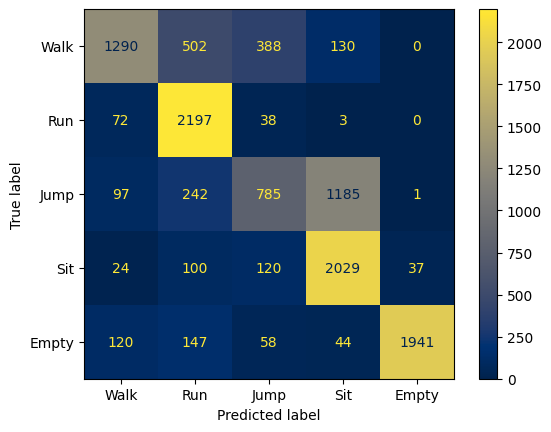

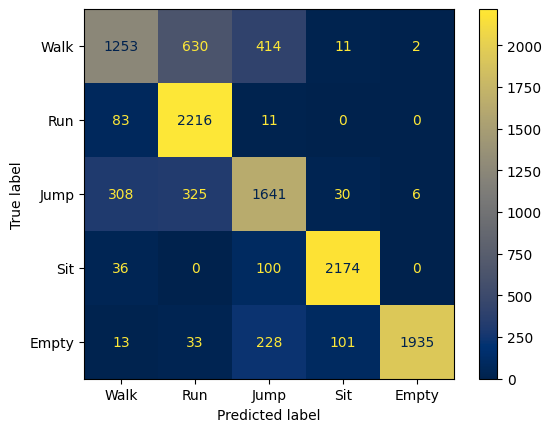

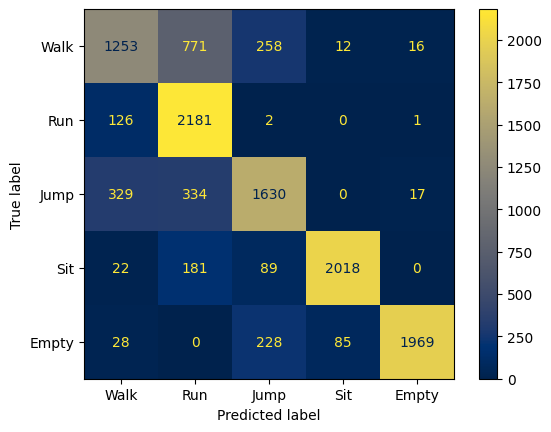

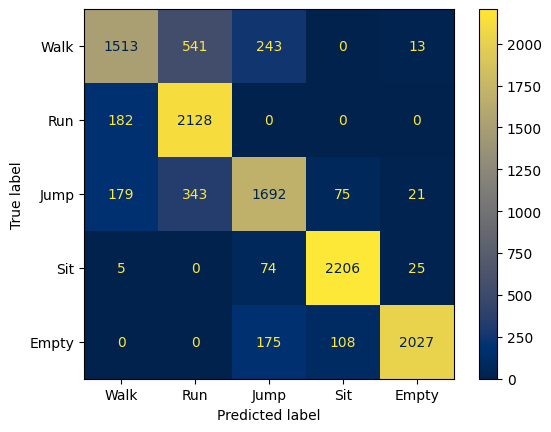

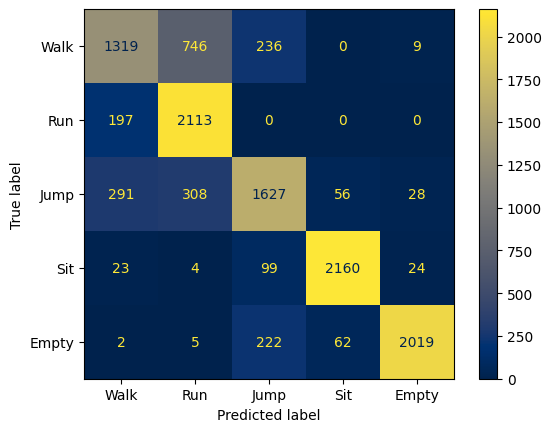

In [20]:
components = list(range(1, 11)) + list(range(15, 41, 5))
levels = [2**i for i in range(1, 8)]
antenna = 0

results = []

for num_components in components:
    for num_levels in levels:
        print(f"------------------------- Running experiment for {num_components} components with {num_levels} levels -------------------------")
        dump_directory =  os.path.join(base_directory, f'{num_components}_components/dumps/{num_components}components_{num_levels}lvls_single_antenna_{antenna}.pkl')
        
        # Load data
        X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment_reconstructed(dump_directory)
        
        # Run model
        name = "No-Fused-1"
        run_edl_experiment(name, num_components, num_levels, X_train, y_train_dummy)

        # Test model
        accuracy = results_test(num_components, num_levels, dump_directory)
        print(f"RESULT max accuracy: {accuracy}")
        results.append(
            {
                "components": num_components,
                "num_levels": num_levels,
                "accuracy": accuracy
            })
        

results_df = pd.DataFrame(results)
results_df.to_csv('results.csv', index=False)

In [63]:
df_accuracy = pd.read_csv('results.csv')
df_bits = pd.read_csv('bit_results_single_antenna_0.csv')
df = pd.merge(df_accuracy, df_bits, on=['target', 'num_levels'])

df.to_csv('final.csv', index=False)

In [ ]:
auc_bit = pd.read_csv('final.csv')

plt.figure(figsize=(20, 10))
for target in auc_bit['target'].unique():
    target_data = auc_bit[auc_bit['target'] == target]
    #plt.plot(target_data['QT_win_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{target} levels')
    plt.plot(target_data['QT_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{target} levels')
plt.ylim(0.8, 1)
plt.title('Accuracy and Bits Comparison (quantized data)')
plt.xlabel('Bits per symbol')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
#plt.savefig(os.path.join('accuracy_bit_comparison.png'))
plt.show()

## Single Run

### Define and run the experiments

In [ ]:
experiments = []
"""for i in range(1, 5):
    experiments.append("No-Fused-%d" % i)
experiments.append("Early-Fusing")
experiments.append("Early-Fusing3")
experiments.append("Delayed-Fusing")
"""

experiments.append("No-Fused-1")
print(f'Experiments to run: {experiments}')

Either train the models from scratch or use the ones already available.

In [ ]:
train_from_scratch = True
reconstructed = True

if train_from_scratch:
    for exp in experiments:
        print(exp)
        print("Loading data")
        X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment(exp, reconstructed=reconstructed)
        
        print("Fit model and save")
        run_edl_experiment(exp, X_train, y_train_dummy)
else:
    !wget https://zenodo.org/record/7983057/files/KERAS_models.zip
    !unzip -o KERAS_models.zip
    !rm KERAS_models.zip

In [ ]:
experiments_res = []
"""for i in range(1, 5):
   experiments_res.append("No-Fused-%d" % i)
experiments_res.append("Early-Fusing")
experiments_res.append("Early-Fusing3")
experiments_res.append("Delayed-Fusing")"""

experiments_res.append("No-Fused-1")
for _e in experiments_res:
    accuracy = results_test(_e, reconstructed)
    print(accuracy)